In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import keras
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import  Adam
from keras import regularizers
from keras import backend as K
from keras.layers import Convolution2D, MaxPooling2D

import IPython.core.display as di
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)
pd.options.mode.chained_assignment = None

Using TensorFlow backend.


In [2]:
def imp(path):
    df = pd.read_csv(path)
    del df["Unnamed: 0"]
    print(df.shape)
    df1 = df.iloc[:, :4]
    df1 = df1.sort(["SrcAddr","DstAddr","StartTime"], ascending = True)
    print(df1.shape)
    print("Only use IP address")
    print(df1.head())
    return df1

In [3]:
df = imp("st_ctu13.csv")

(2619340, 31)


/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


(2619340, 4)
Only use IP address
   StartTime        SrcAddr        DstAddr  label
0    2165588  1.108.169.143  147.32.84.229      0
1    1436316      1.11.9.68  147.32.84.229      0
2    1358104     1.112.1.75  147.32.84.229      0
3    1112468  1.112.109.236  147.32.84.229      0
4    1131769  1.112.111.184  147.32.84.229      0


> 先將資料取出成對IP並藉由StartTime排列。
因為可能會有testing set出現training set沒出現過的IP的情況，  
所以我們打算將IP轉成一個timewindow裡面的degree，  
在之後做testing的時候就可以也轉化成degree去做代表。

# IP address ranking in time_window and sort by IP address

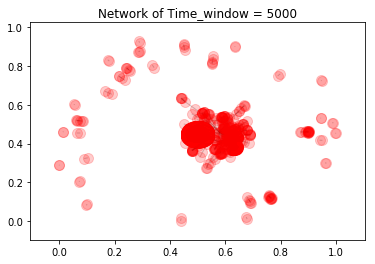

In [4]:
i = 0
time_window = 5000
df1 = df[((i)*time_window <= df.StartTime) & (df.StartTime < (i+1)*time_window)]
G = nx.from_pandas_dataframe(df1, 'SrcAddr', 'DstAddr', edge_attr = True)
nx.shortest_path(G)
nx.draw_networkx(G, node_size = 100, alpha = 0.2, with_labels = False)
plt.title("Network of Time_window = 5000")
plt.show()

In [5]:
### count degree
deg = pd.DataFrame(G.degree_iter())
deg.columns = ["SrcAddr", "degree"]
deg["DstAddr"] = deg.SrcAddr
print('Count of IP in one time_window:', deg.shape[0])

### to rank
deg["rank"] = deg.degree.rank(axis = 0, method = 'average', numeric_only = None,
                             na_option = 'keep', ascending = False, pct = False)
print("Rank and Degree")
deg.head(10)

Count of IP in one time_window: 3441
Rank and Degree


,SrcAddr,degree,DstAddr,rank
0,1.144.156.226,1,1.144.156.226,1785.0
1,147.32.84.229,2954,147.32.84.229,1.0
2,1.155.150.224,1,1.155.150.224,1785.0
3,1.161.139.96,1,1.161.139.96,1785.0
4,1.72.0.253,1,1.72.0.253,1785.0
5,107.10.133.94,1,107.10.133.94,1785.0
6,108.196.204.150,1,108.196.204.150,1785.0
7,108.41.164.45,1,108.41.164.45,1785.0
8,108.41.71.165,1,108.41.71.165,1785.0
9,108.78.14.157,1,108.78.14.157,1785.0


In [6]:
def IP2deg(df, deg):
    df1 = df.merge(deg.drop(["degree","DstAddr"], axis=1), how = 'inner', on = "SrcAddr")
    df2 = df1.merge(deg.drop(["degree","SrcAddr"], axis=1), how = 'inner', on = "DstAddr")
    return df2

In [7]:
df_deg = IP2deg(df1, deg)
df_deg.columns = ["StartTime","SrcAddr1","DstAddr1","label","SrcAddr","DstAddr"]
print("Merge to original data")
df_deg.head()

Merge to original data


,StartTime,SrcAddr1,DstAddr1,label,SrcAddr,DstAddr
0,2150,1.144.156.226,147.32.84.229,0,1785.0,1.0
1,2954,1.155.150.224,147.32.84.229,0,1785.0,1.0
2,2248,1.161.139.96,147.32.84.229,0,1785.0,1.0
3,2514,1.72.0.253,147.32.84.229,0,1785.0,1.0
4,1073,107.10.133.94,147.32.84.229,0,1785.0,1.0


### For Loop

In [8]:
time_window = 5000
size_of_window = int((df.shape[0]) / time_window)

y = []
for i in range(size_of_window):
    df3 = df[(i*time_window <= df.StartTime) & (df.StartTime < (i+1)*time_window)]
    G = nx.from_pandas_dataframe(df3, 'SrcAddr', 'DstAddr', edge_attr = True)
    
    deg = pd.DataFrame(G.degree_iter())
    deg.columns = ["SrcAddr", "degree"]
    deg["DstAddr"] = deg.SrcAddr
    deg["rank"] = deg.degree.rank(axis = 0, method = 'average', numeric_only = None,
                                  na_option = 'keep', ascending = False, pct = False)
    df_deg = IP2deg(df3, deg)
    df_deg.columns = ["StartTime","SrcAddr1","DstAddr1","label","SrcAddr","DstAddr"]
    y.append(df_deg)
    
appended_data = pd.concat(y, axis = 0)
appended_data = appended_data.reset_index(drop = True)
print(appended_data.shape)
appended_data["label"].value_counts()

(2615000, 6)


0    2586676
1      28324
Name: label, dtype: int64

In [ ]:
### Sort by IP and StartTime
def transfer(df):
    df = df.sort(["SrcAddr","DstAddr","StartTime"], ascending = True)
    df1 = df.drop(["SrcAddr1","DstAddr1","StartTime"], axis = 1)
    print("Size of dataset", df1.shape[0])
    print("======= Label of Sort IP =======")
    print(df1["label"].value_counts())
    return df1

In [ ]:
### Training and Testing
training_size = int(size_of_window * 0.8) * time_window
data = appended_data.iloc[:training_size,:]
test = appended_data.iloc[training_size:,:]

df_rank = transfer(data)
df_rank_test = transfer(test)

/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [ ]:
def reshape(df):
    x = np.array(df[["SrcAddr", "DstAddr"]])
    y = np.array(df["label"])
    
    seq_length = 1
    X = np.reshape(x, (len(x), seq_length, 2))
    X = X / np.max(df_rank.SrcAddr)
    
    Y = np_utils.to_categorical(y)
    
    print(X.shape, Y.shape)
    return X, Y

In [ ]:
print("Reshape Training and Testing Dataset")
X_train, y_train = reshape(df_rank)
X_test, y_test = reshape(df_rank_test)

In [ ]:
### Baseline and Class_weight
a = pd.DataFrame(y_test, columns=["N", "B"])
b = pd.DataFrame(a["B"].value_counts())
base = a[a.B == 1].shape[0] / a.shape[0]
class_weight = b.iloc[0, 0] / b.iloc[1, 0]

print("Base line:", (1-base))
print("class weight:", class_weight)

In [ ]:
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, return_sequences = False,
               input_shape = (X_train.shape[1], X_train.shape[2])))
#model.add(LSTM(512, return_sequences = True))
#model.add(LSTM(512, return_sequences = True))
#model.add(LSTM(512, return_sequences = True))
#model.add(LSTM(512))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
model.summary()

In [ ]:
batch_size = int(X_train.shape[0]*0.0001)
nb_epoch = 2

history = model.fit(X_train, y_train,
                    batch_size = batch_size,  
                    epochs = nb_epoch,  
                    verbose = 1,  
                    validation_split = 0.1,  
                    class_weight = {0: 1, 1: class_weight})

loss = history.history.get('loss')
acc = history.history.get('acc')

''' Access the performance on validation data '''
val_loss = history.history.get('val_loss')
val_acc = history.history.get('val_acc')

''' Visualize the loss and accuracy of both models'''
import matplotlib.pyplot as plt
plt.figure(0)
plt.subplot(121)
plt.plot(range(len(loss)), loss,label = 'Training')
plt.plot(range(len(val_loss)), val_loss,label = 'Validation')
plt.title('Loss')
plt.legend(loc='upper left')
plt.subplot(122)
plt.plot(range(len(acc)), acc,label = 'Training')
plt.plot(range(len(val_acc)), val_acc,label = 'Validation')
plt.title('Accuracy')
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Validation score:', score[0])
print('Validation accuracy:', score[1])

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

y_true = y_test[:,1]
y_pred = model.predict_classes(X_test)
cm = confusion_matrix(y_true, y_pred, labels = None, sample_weight = None)

np.set_printoptions(precision=2)
class_names = ["0", "1"]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes = class_names,
                      title = 'Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes = class_names, normalize = True,
                      title = 'Normalized confusion matrix')

plt.show()

# Testing

In [ ]:
test_time = imp("testctu13.csv")

In [ ]:
time_window = 5000
size_of_window = int((test_time.shape[0]) / time_window)

y = []
for i in range(size_of_window):
    df3 = test_time[(i*time_window <= test_time.StartTime) & (test_time.StartTime < (i+1)*time_window)]
    G = nx.from_pandas_dataframe(df3, 'SrcAddr', 'DstAddr', edge_attr = True)
    
    deg = pd.DataFrame(G.degree_iter())
    deg.columns = ["SrcAddr", "degree"]
    deg["DstAddr"] = deg.SrcAddr
    deg["rank"] = deg.degree.rank(axis = 0, method = 'average', numeric_only = None,
                                  na_option = 'keep', ascending = False, pct = False)
    df_deg = IP2deg(df3, deg)
    df_deg.columns = ["StartTime","SrcAddr1","DstAddr1","label","SrcAddr","DstAddr"]
    y.append(df_deg)
    
appended_test = pd.concat(y, axis = 0)
appended_test = appended_test.reset_index(drop = True)
print(appended_test.shape)
appended_test["label"].value_counts()

In [ ]:
test_rank = transfer(appended_test)
print("Training and Testing")
test_X, test_y = reshape(test_rank)

In [ ]:
score = model.evaluate(test_X, test_y, verbose = 0)
print("===")
print('Test score:', score[0])  
print('Test accuracy:', score[1])

In [ ]:
y_true = test_y[:,1]
y_pred = model.predict_classes(test_X)

In [ ]:
cm = confusion_matrix(y_true, y_pred, labels = None, sample_weight = None)

np.set_printoptions(precision=2)
class_names = ["0", "1"]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes = class_names,
                      title = 'Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes = class_names, normalize = True,
                      title = 'Normalized confusion matrix')

plt.show()